# Linear Regression of an indicator matrix
In this first part we are going to illustrate the problem of using linear regression in multi-class classification problems. This example is inspired from Figure 4.2 in The Elements of Statistical Learning (Hastie et al).


Let's first generate some synthetic data that allows us to demonstrate the problem.

In [1]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import LabelBinarizer,  PolynomialFeatures

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
K=3
sample_size = [600, 600, 600]
centers=[[1, 1], [10, 10], [20,20]]
stds=[1, 1.5, 2]
X, y = make_blobs(n_samples=sample_size, centers=centers, cluster_std=stds, n_features=2, random_state=0)

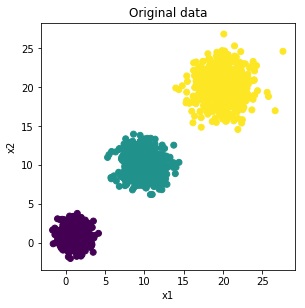

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Original data')
plt.show()

Now, let's make apply the linear regression algorithm with indicator matrix algorithm. 
Let's first build our indicator matrix.

In [4]:
#using object LabelBinarizer from scikit-lear we can convert our labels into the indicator matrix Y
enc = LabelBinarizer()
enc.fit([0,1,2])
Y = enc.transform(y)
print(Y)

#We also prepare our data X by adding the dummy variable
poly = PolynomialFeatures(1)  
X = poly.fit_transform(X)

[[1 0 0]
 [0 1 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 0 1]]


In [5]:
#We will use the same code we used for linear regression
from numpy import linalg
def least_squares(X, y):
    X_t = np.transpose(X) #X^T
    X_t_X = X_t.dot(X)    #X^TX
    X_T_y = X_t.dot(y)    #X^Ty
    
    #An alternative and more efficient way to compute: using a linear solver to solve the eq Ax = b
    w = linalg.solve(X_t_X, X_T_y)
    
    return w

In [6]:
W = least_squares(X,Y)
print(W)

[[ 0.85653299  0.35153516 -0.20806815]
 [-0.02402854 -0.00346642  0.02749496]
 [-0.02679106  0.00167516  0.02511591]]


In [7]:
#Classification stage: 
#1) computes f for each class and 
#2) then classifies x as the class for which f is maximal.
f_hat = np.array([])
for c in range(0,K):
    f_tmp = np.sum(X * W[:,c], axis=1).reshape(-1,1)
    if c > 0:
        f_hat = np.append(f_hat, f_tmp, axis = 1) 
    else:
        f_hat = f_tmp
        
y_hat = np.argmax(f_hat, axis=1)

In [8]:
def get_x1(W1,W2,x2):
    '''Auxiliary function to draw the decision boundaries. It computes values of x1 given x2. 
    Remember the decision boundary is, for two classes 1 and 2, where XW_1 = XW_2'''
    x1 = ((W2[0] - W1[0]) + (W2[2] - W1[2])*x2)/(W1[1] - W2[1])
    
    return np.squeeze(x1)

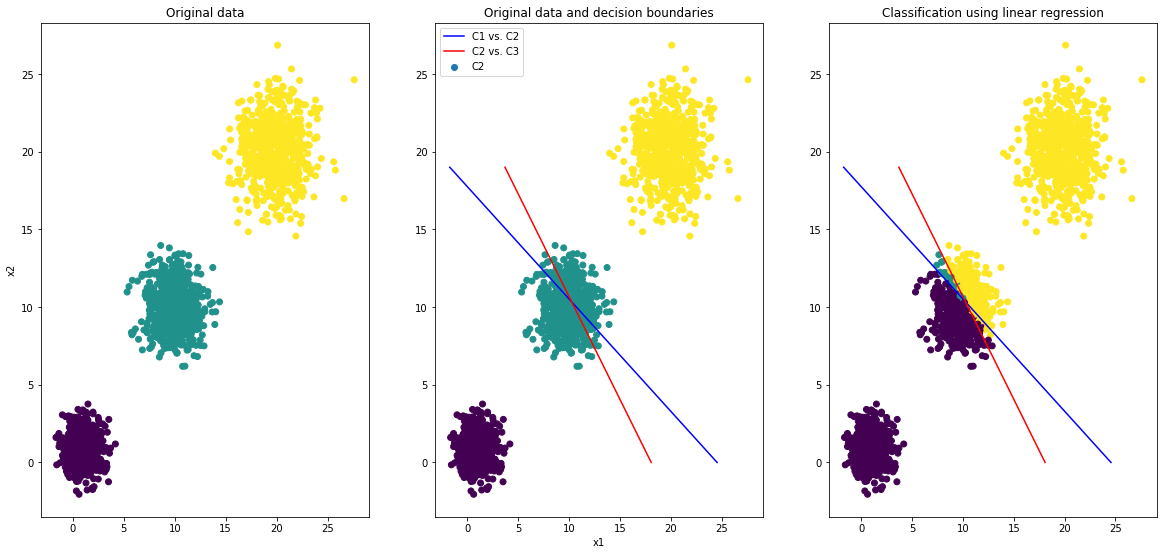

In [9]:
plt.rcParams['figure.figsize'] = [20, 20]

x_min = 0
x_max = 20

h = 1
xx = np.arange(x_min, x_max, h)

line_1_x1 = get_x1(W[:,0], W[:,1], xx) 
line_2_x1 = get_x1(W[:,1], W[:,2], xx) 

plt.subplot(231)
plt.scatter(X[:, 1], X[:, 2], c=y)
plt.ylabel('x2')
plt.title('Original data')

plt.subplot(232)
plt.scatter(X[:, 1], X[:, 2], c=y)

plt.plot(line_1_x1,xx, c="blue")

plt.plot(line_2_x1,xx, c="red")
plt.xlabel('x1')
plt.legend(['C1 vs. C2', 'C2 vs. C3', 'C2'])
plt.title('Original data and decision boundaries')

plt.subplot(233)
plt.scatter(X[:, 1], X[:, 2], c=y_hat)



plt.plot(line_1_x1,xx, c="blue")
plt.plot(line_2_x1,xx, c="red")
plt.title('Classification using linear regression')

plt.show()



### From The Elements of Statistical Learning (p. 105):<br>
"There is a serious problem with the regression approach when the number of classes $K\geq 3$, especially prevalent when K is large. Because of the rigid nature of the regression model, classes can be *masked* by others."


"The three classes are perfectly separated by linear decision boundaries, yet linear regression misses the middle class."



**Exercise**: This example uses three classes obtained using the make_blobs functions from scikit-learn. Try to play around by: 1) modifying means and standard deviations of the classes, 2) changing the number of classes (no lower than 3) and/or 3) using other data. </p>
Can you find cases where the linear regressor works well?

# Linear Discriminant Analysis
Now, let's implement LDA and see how does our classification problem looks like.

<p>We will pretend not to know the means of our three classes</p>

In [10]:
#Let's estimate the parameters.
N = np.sum(sample_size)
proportions = sample_size / np.sum(sample_size)

means = []
for k in range(0,K):
    means.append(((y == k).dot(X[:,1:])) / sample_size[k])
    
cov_per_class = []
for k in range(0,K):
    squared_term = (X[:,1:] - means[k])**2
    cov_per_class.append(((y == k).dot(squared_term)))
    
covariance = np.sum(cov_per_class,axis=0)/(N-K)

print('Prior:', proportions)
print('Means:', means)
print('Covariance:', covariance)

Prior: [0.33333333 0.33333333 0.33333333]
Means: [array([0.98825492, 0.96834315]), array([ 9.90717798, 10.03119458]), array([19.84559908, 20.01590891])]
Covariance: [2.31377112 2.33148556]


In [11]:
#Now let's estimate the linear discriminant functions for each sample

mean_over_covariance = np.divide(means,covariance)
log_prior = np.log(proportions)

ldf = np.array([])
for k in range(0,K):
    ldf_tmp = (X[:,1:].dot(mean_over_covariance[k,:])-0.5*means[k].dot(mean_over_covariance[k]) - log_prior[k]).reshape(-1,1)

    if k > 0:
        ldf = np.append(ldf, ldf_tmp, axis = 1) 
    else:
        ldf = ldf_tmp                         

y_hat_lda = np.argmax(ldf, axis=1)

In [12]:
def get_x1_lda(covariance, mean_1, mean_2, prior_1, prior_2, x2):
    '''Auxiliary function to obtain the decision boundaries of the classifier when using LDA. 
    Works for only 2-D input spaces'''
    
    b1 = np.divide(mean_1,covariance)
    b2 = np.divide(mean_2,covariance)

    a1 = -0.5*mean_1.dot(b1) + np.log(prior_1)
    a2 = (-0.5*mean_2.dot(b2) + np.log(prior_2)) 

    x1 = ((a2 - a1) + (b2[1] - b1[1])*x2)/(b1[0]-b2[0])
    
    return x1

In [13]:
line_1_lda_x1= get_x1_lda(covariance, means[0], means[1], proportions[1], proportions[0], xx)
line_2_lda_x1= get_x1_lda(covariance, means[1], means[2], proportions[2], proportions[1], xx)

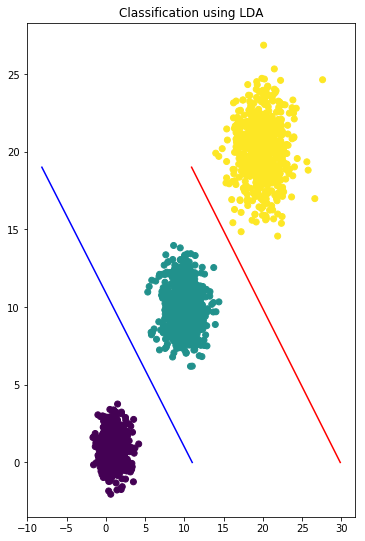

In [14]:
plt.subplot(231)
plt.scatter(X[:, 1], X[:, 2], c=y_hat_lda)
plt.plot(line_1_lda_x1,xx, c="blue")
plt.plot(line_2_lda_x1,xx, c="red")
plt.title('Classification using LDA')
plt.show()

**Exercise:** Refactor the provided and create a function LDA_classifier that receives as parameters the input $X$ and the ground truth $y$. It should return the model parameters. Then create another function called predict_LDA that received the parameters and some input data $X$. Use these two functions to test the LDA classifier over more complex datasets. Part of the exercise includes you exploring ways to generate more complex synthetic data.

# Logistic Regression
Finally, we are going to solve our problem using logistic regression. In this case, we are gonna use the built in function of scikit-learn.

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X[:,1:], y)
y_hat_lr = logreg.predict(X[:,1:])

In [17]:
def boundaries_lr(w0_1, w0_2, W_1, W_2, x2):
    '''Auxiliary function to determine the boundaries W0_1 + W_1^Tx = W0_2 + W_2^Tx: 
       Notice that the final expression is pretty much the same for every case:
       linear regresion, lda or logistic regression'''
    
    x1= ((w0_2 - w0_1) + (W_2[1] - W_1[1])*x2)/(W_1[0] - W_2[0])
    return x1

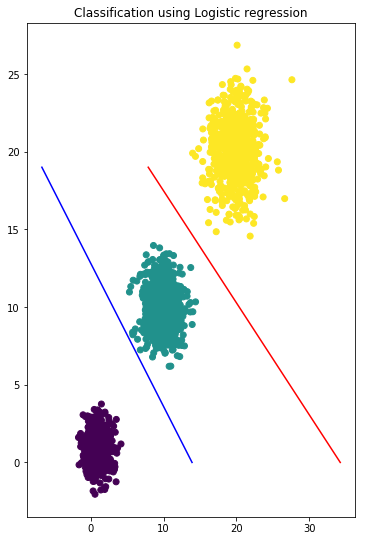

In [18]:
line_1_lr_x1= boundaries_lr(logreg.intercept_[0],logreg.intercept_[1], logreg.coef_[0],logreg.coef_[1], xx)
line_2_lr_x1= boundaries_lr(logreg.intercept_[1],logreg.intercept_[2], logreg.coef_[1],logreg.coef_[2], xx)
plt.subplot(231)
plt.scatter(X[:, 1], X[:, 2], c=y_hat_lr)
plt.plot(line_1_lr_x1,xx, c="blue")
plt.plot(line_2_lr_x1,xx, c="red")
plt.title('Classification using Logistic regression')
plt.show()



## In summary

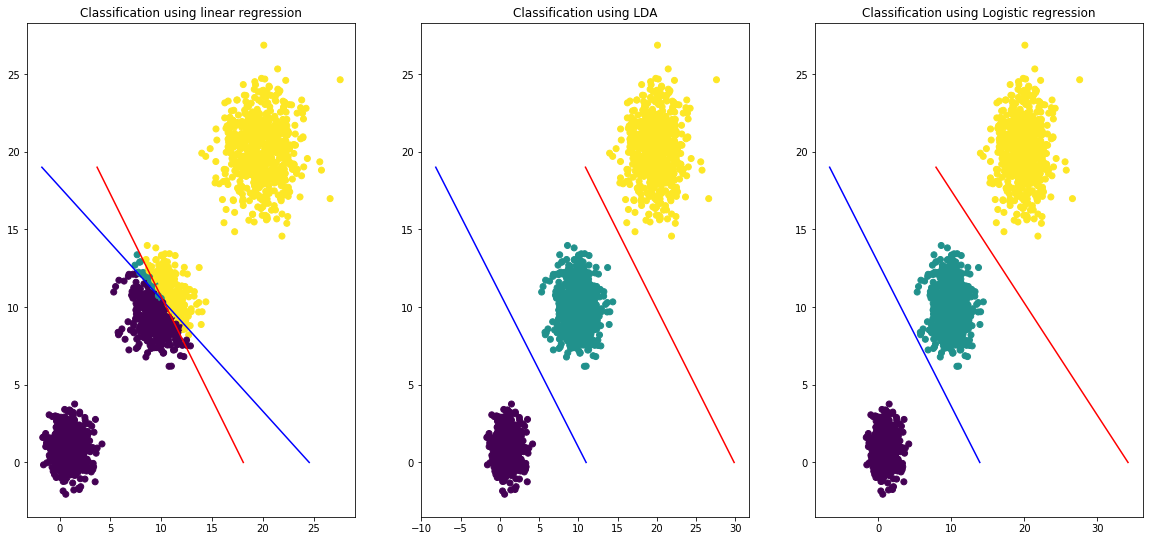

In [19]:
plt.subplot(231)
plt.scatter(X[:, 1], X[:, 2], c=y_hat)

x_min = 0
x_max = 20

h = 1
xx = np.arange(x_min, x_max, h)

line_1_x1 = get_x1(W[:,0], W[:,1], xx) 
line_2_x1 = get_x1(W[:,1], W[:,2], xx) 

plt.plot(line_1_x1,xx, c="blue")
plt.plot(line_2_x1,xx, c="red")
plt.title('Classification using linear regression')

plt.subplot(232)
plt.scatter(X[:, 1], X[:, 2], c=y_hat_lda)
plt.plot(line_1_lda_x1,xx, c="blue")
plt.plot(line_2_lda_x1,xx, c="red")
plt.title('Classification using LDA')

plt.subplot(233)
plt.scatter(X[:, 1], X[:, 2], c=y_hat_lr)
plt.plot(line_1_lr_x1,xx, c="blue")
plt.plot(line_2_lr_x1,xx, c="red")
plt.title('Classification using Logistic regression')
plt.show()

# Appendix: The sigmoid function
A demonstration of the sigmoid function equivalent representations

In [20]:
x_min = -5
x_max = 5

h = 0.01
xx = np.arange(x_min, x_max, h)

y1 = 1/(1+np.exp(-xx))
y2 = np.divide(np.exp(xx),(1+np.exp(xx)))
y3 = 1 - (1/(1+np.exp(xx)))

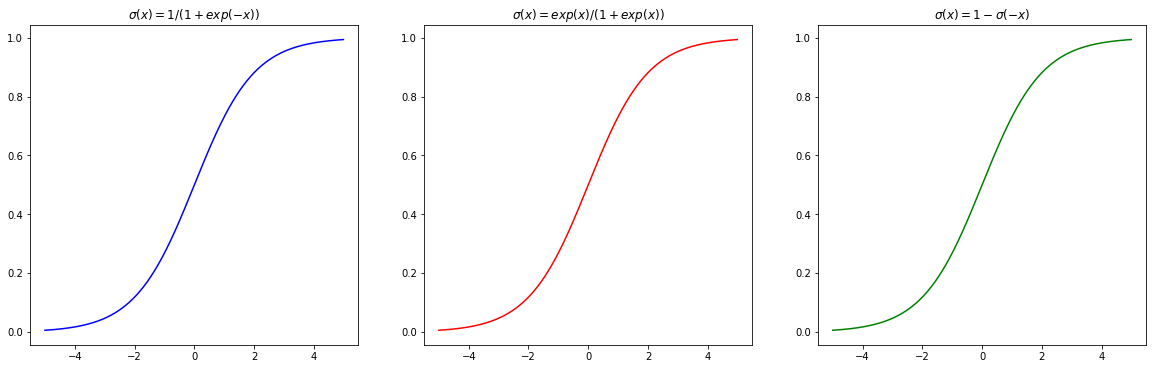

In [21]:
plt.subplot(331)
plt.plot(xx,y1, c="blue")
plt.title('$\sigma(x)=1/(1+exp(-x))$')
plt.subplot(332)
plt.plot(xx,y2, c="red")
plt.title('$\sigma(x)=exp(x)/(1+exp(x))$')
plt.subplot(333)
plt.title('$\sigma(x)=1-\sigma(-x)$')
plt.plot(xx,y3, c="green")

plt.show()